In [1]:
import pandas as pd
import numpy as np
from datetime import datetime 

# To split the dataset into train and test datasets
from sklearn.model_selection import train_test_split

# To model the Gaussian Navie Bayes classifier
from sklearn.naive_bayes import GaussianNB

# To calculate the accuracy score of the model
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

import matplotlib.pyplot as plt
%matplotlib inline

#### Dropping Features Pt1
Outcome subtype does not matter to the model. The name of the animal does not affect adoption as no on ever keeps the name.

In [2]:
df = pd.read_csv("aac_shelter_outcomes.csv")

df = df[['animal_id','age_upon_outcome','animal_type', 'breed', 'color', 'date_of_birth', 'datetime', 'outcome_type', 'sex_upon_outcome']]
df.isnull().sum()

animal_id            0
age_upon_outcome     8
animal_type          0
breed                0
color                0
date_of_birth        0
datetime             0
outcome_type        12
sex_upon_outcome     2
dtype: int64

#### Provide written justification explaining why you selected particular methods for dealing with missing values:

removing all null ages, sex, and type because replacing these would be difficult to do right. 
There is no average for any of these execpt maybe age. 
however, because distribtion of age is so skewed replacing with the average would probabaly be misleading. 
and since these are 22 rows out of 78256 they will be insigificant to our classification model. 

In [3]:
df = df.dropna()
df.shape
df.isnull().sum()

animal_id           0
age_upon_outcome    0
animal_type         0
breed               0
color               0
date_of_birth       0
datetime            0
outcome_type        0
sex_upon_outcome    0
dtype: int64

In [4]:
df.head()

,animal_id,age_upon_outcome,animal_type,breed,color,date_of_birth,datetime,outcome_type,sex_upon_outcome
0,A684346,2 weeks,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,Transfer,Intact Male
1,A666430,1 year,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,Transfer,Spayed Female
2,A675708,1 year,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,Adoption,Neutered Male
3,A680386,9 years,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,Transfer,Neutered Male
4,A683115,5 months,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,Euthanasia,Unknown


In [5]:
#all legitimate categories, obviously keeping them. 
df.groupby(['sex_upon_outcome']).agg({'sex_upon_outcome': 'count'})

,sex_upon_outcome
sex_upon_outcome,
Intact Female,9139
Intact Male,9544
Neutered Male,27782
Spayed Female,25203
Unknown,6569


#### Transforming all all the age categories into readable, consistent data by subtrcting the date_of_birth age from the date_time.

We know this method works because we validated it with the original data

In [6]:
date_of_birth = df['date_of_birth'].tolist()
date_time = df['datetime'].tolist()
age = []

def days_between(d1, d2):
    d1 = datetime.strptime(d1, '%Y-%m-%d %H:%M:%S')
    d2 = datetime.strptime(d2, '%Y-%m-%d %H:%M:%S')
    age.append((d2 - d1).days/365)


for i in range (len(date_of_birth)):
    date_of_birth[i] = date_of_birth[i].replace('T', ' ')
    date_time[i] = date_time[i].replace('T', ' ')
    days_between(date_of_birth[i], date_time[i])


#### Checking for outliers. density plot.

Not going to touch age outliers because these values are singificant and matter to the classification model because these are legitamite reasons why someone may/may not adopt a pet. 

In [7]:
df['age'] = age

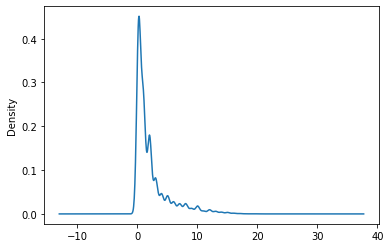

In [8]:
df['age'].plot.kde()

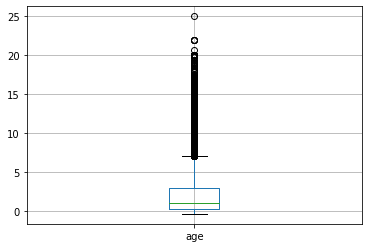

In [9]:
df.boxplot()

After looking into sub zero ages we foung that animals that have an age of 
below zero have incorrect birth or age upon outcome dates. So we are going to not look at any data below zero as it is ruining our model

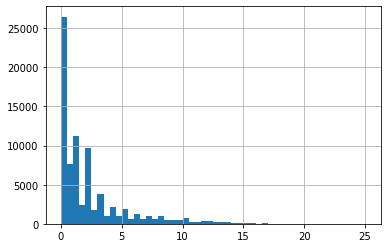

In [10]:
df = df.query("age >= 0")
df["age"].hist(bins = 50)

### Center, Scale, and Tranform data

No need to center, scale, or tranform since everything will become categorical data so can't even do that.

#### Making age buckets

In [11]:
df["age_buckets"] = pd.cut(df.age, [0, .5, 1, 1.5, 2, 3, 4, 5, 6, 10, 15, 26], labels=["age 0-.5", "age .5-1", "age 1-1.5", "age 1.5-2", "age 2-3", "age 3-4", "age 4-5", "age 5-6", "age 6-7", "age 10-15", "age 15-26"], include_lowest=True)
df.head()

,animal_id,age_upon_outcome,animal_type,breed,color,date_of_birth,datetime,outcome_type,sex_upon_outcome,age,age_buckets
0,A684346,2 weeks,Cat,Domestic Shorthair Mix,Orange Tabby,2014-07-07T00:00:00,2014-07-22T16:04:00,Transfer,Intact Male,0.041096,age 0-.5
1,A666430,1 year,Dog,Beagle Mix,White/Brown,2012-11-06T00:00:00,2013-11-07T11:47:00,Transfer,Spayed Female,1.002740,age 1-1.5
2,A675708,1 year,Dog,Pit Bull,Blue/White,2013-03-31T00:00:00,2014-06-03T14:20:00,Adoption,Neutered Male,1.175342,age 1-1.5
3,A680386,9 years,Dog,Miniature Schnauzer Mix,White,2005-06-02T00:00:00,2014-06-15T15:50:00,Transfer,Neutered Male,9.041096,age 6-7
4,A683115,5 months,Other,Bat Mix,Brown,2014-01-07T00:00:00,2014-07-07T14:04:00,Euthanasia,Unknown,0.495890,age 0-.5


#### outcome will now only be adopted(1) or not adopted (0)

In [12]:
outcome = df['outcome_type'].tolist()

for i in range (len(outcome)):
    if outcome[i] == "Adoption":
        outcome[i] = 1
    else:
        outcome[i] = 0

df["outcome"] = outcome

### Keeping only valueable features, label encoding the catergorical variables, and setting up the classification model
  
Only kept features that are most likely to matter to the consumer. Animal type, breed, color, age the sex upon are all going to matter to the adopter. Things like animal ID don't matter. Datetime and DOB are dropped as we converted that to age. 

In [13]:
def label_encode(df, columns):
    for col in columns:
        le = LabelEncoder()
        col_values_unique = list(df[col].unique())
        le_fitted = le.fit(col_values_unique)
 
        col_values = list(df[col].values)
        #le.classes_
        col_values_transformed = le.transform(col_values)
        df[col] = col_values_transformed

features = df[['animal_type','breed','color', 'sex_upon_outcome','age_buckets']]

label_encode(features, features.columns.values)

target = df[['outcome']]

label_encode(target, target.columns.values)

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size = 0.20, random_state = 10)

features.head()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.


,animal_type,breed,color,sex_upon_outcome,age_buckets
0,1,937,321,1,1
1,2,255,474,3,2
2,2,1612,119,2,2
3,2,1467,463,2,10
4,4,253,122,4,1


### Setting up Cross Validation Function

In [14]:
def crossvalidation (x, y):
    from sklearn.model_selection import KFold # import KFold
    from sklearn.model_selection import cross_val_score, cross_val_predict
    y = y.values.ravel()
    model.fit(x, y)
    kf = KFold(n_splits=10,random_state=2, shuffle=False)
    scores = cross_val_score(model, x, y, cv=kf)
    
    print('Cross-validated scores:', scores.mean())
    

### Naive Bayes

In [15]:
model = GaussianNB()
model.fit(features_train, target_train.values.ravel())
target_pred = model.predict(features_test)
target_pred

array([0, 0, 0, ..., 1, 0, 0])

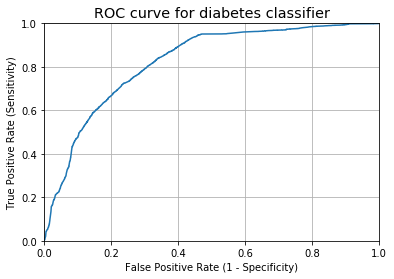

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt



# IMPORTANT: first argument is true values, second argument is predicted probabilities

# we pass y_test and y_pred_prob

target_pred_prob = model.predict_proba(features_test)[:, 1]

# we do not use y_pred_class, because it will give incorrect results without generating an error
# roc_curve returns 3 objects fpr, tpr, thresholds
# fpr: false positive rate
# tpr: true positive rate
fpr, tpr, thresholds = metrics.roc_curve(target_test, target_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [17]:
from sklearn import metrics
print("Naive Bayes")
print("Accuracy Score  = " + str(metrics.accuracy_score(target_test, target_pred)))
crossvalidation(features, target)
print("ROC SCORE: " + str(metrics.roc_auc_score(target_test, target_pred_prob)))

Naive Bayes
Accuracy Score  = 0.7309855554135242
Cross-validated scores: 0.7315319122886108
ROC SCORE: 0.8229494335253322


### KNN

In [18]:
#Training the model with KNN

from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=10)
model.fit(features_train, target_train.values.ravel())
y_pred_class = model.predict(features_test)
y_pred_class

array([0, 1, 0, ..., 1, 1, 0])

KNN
Accuracy Score  = 0.7070177681196472
Cross-validated scores: 0.7143897684100142
Auc Score: 0.8466697393629725


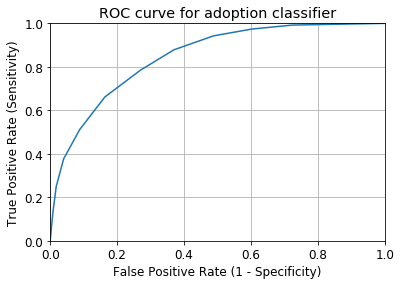

In [19]:
print("KNN")
print("Accuracy Score  = " + str(metrics.accuracy_score(target_test, y_pred_class)))
crossvalidation(features, target)

y_pred_prob = model.predict_proba(features_test)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(target_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for adoption classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print("Auc Score: "+ str(metrics.roc_auc_score(target_test, y_pred_prob)))

### Random Forest

In [20]:
from sklearn.ensemble import RandomForestClassifier

# instantiate model
model = RandomForestClassifier(random_state=1, max_depth=10)

# fit model
model.fit(features_train, target_train.values.ravel())

y_pred = model.predict(features_test)
y_pred

//anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([0, 0, 0, ..., 1, 0, 0])

Accuracy Score = 0.7644765435255018
Cross-validated scores: 0.7646269009950498
Auc Score: 0.8652716033891295


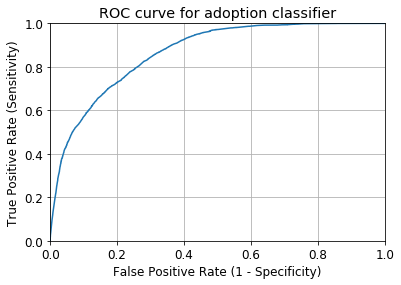

In [21]:
print("Accuracy Score = " + str(metrics.accuracy_score(target_test, y_pred)))

crossvalidation(features, target)

y_pred_prob = model.predict_proba(features_test)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(target_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for adoption classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print("Auc Score: "+ str(metrics.roc_auc_score(target_test, y_pred_prob)))

### SVM

In [22]:
from sklearn import svm
from sklearn.ensemble import BaggingClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC


# instantiate model
n_estimators = 10
model = OneVsRestClassifier(BaggingClassifier(SVC(kernel = 'rbf', probability=True), max_samples=1.0 / n_estimators, n_estimators=n_estimators))

# fit model
model.fit(features_train, target_train.values.ravel())

y_pred_class = model.predict(features_test)

//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The defa

In [23]:
print("Accuracy Score  = " + str(metrics.accuracy_score(target_test, y_pred_class)))

Accuracy Score  = 0.6970471686053944


In [24]:
crossvalidation(features, target) 

//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The defa

//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The defa

//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The defa

//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The defa

//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Cross-validated scores: 0.7050582085690129


In [ ]:
y_pred_prob = model.predict_proba(features_test)[:, 1]

fpr, tpr, thresholds = metrics.roc_curve(target_test, y_pred_prob)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for adoption classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

print("Auc Score: "+ str(metrics.roc_auc_score(target_test, y_pred_prob)))

### Justification

Random forest was the best classification model as it produced both the highest Accuracy Score, cross validated score, and ROC score. This makes sense as there is low correlation between the models. But also, some variables that exist in our model are dependent on other variables. For example, Golden Retriever as a breed only exists in dogs. So it makes sense why decision trees and hence a random forest would be optimal for this model. 

### Paragraph

Our Model (Random Forest) is not a bad one. Its accuracy score is high and the AUC score is high. In this case, its fine that the AUC score is not close to 1.0 because a type II error is not going to be that harmful when it comes to the application of this model in real life. 